In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import sys
sys.executable

'/cm/shared/apps/conda-environments/python39/bin/python'

In [3]:
import os

In [4]:
import copy

In [5]:
os.environ["OMP_NUM_THREADS"] = "2"

In [6]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import scipy.fft as fft
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
import json

In [9]:
import evoMPS.tdvp_uniform as tdvp
import evoMPS.tdvp_sandwich as tdvp_s
import evoMPS.dynamics as dyn
import evoMPS.split_step as ss
import evoMPS.tdvp_common as tm
import evoMPS.matmul as mm

INFO: No c versions of epsilon maps. Compile extension modules for a boost at low bond-dimensions.


In [10]:
import sources.master as mas

In [11]:
import sources.post.overlaps as olaps

## Load parameters and precomputed vacuum state

In [12]:
datadir = "./"
simbase = "direc93/"
simname = "maxD64_dt05RK4"
basedir = datadir + simbase
simdir = basedir + simname + "/"
mom = 0.4085
t = 290
# Choose a time when the tracks are well-separated. Check if "P" is same for t \pm 20 to be sure. 

In [13]:
with open(basedir + "/state_params.json", "r") as f:
    state_params = json.load(f)
state_params

{'J': 1.0,
 'hx': 1.08,
 'hz': 0.006,
 'J2': 0.0,
 'J3': 0.0,
 'J4': 0.0,
 'J5': 0.0,
 'hzx': 0.0,
 'D': 40,
 'vac_tol': 1e-10,
 'N': 1000,
 'ortho_2p': True,
 'symmB': False,
 'pkt_numsites': 400,
 'pkt_sigma': 70,
 'pkt_midpt': 200,
 'pad_mid': 0,
 'pad_out': 0,
 'momentum': 0.4085,
 'ex_lvl': 0}

In [14]:
ham = mas.get_ham(state_params["J"], state_params["hx"], state_params["hz"], state_params["J2"], state_params["J3"],
             state_params["J4"], state_params["J5"], state_params["hzx"])

In [15]:
vac = tdvp.EvoMPS_TDVP_Uniform.from_file(basedir + "vac_uniform.npy", ham)

In [16]:
vac.schmidt_sq()**0.5

array([9.66172261e-01+0.j, 2.56212570e-01+0.j, 2.82587496e-02+0.j,
       7.69106946e-03+0.j, 2.79778099e-03+0.j, 8.10996729e-04+0.j,
       2.64486542e-04+0.j, 8.91349439e-05+0.j, 7.85872446e-05+0.j,
       2.54685092e-05+0.j, 2.41990821e-05+0.j, 9.17483312e-06+0.j,
       7.45662094e-06+0.j, 2.68422910e-06+0.j, 2.25187703e-06+0.j,
       9.16538541e-07+0.j, 8.04420634e-07+0.j, 7.02752440e-07+0.j,
       2.79011540e-07+0.j, 2.51306081e-07+0.j, 2.10646758e-07+0.j,
       8.81384680e-08+0.j, 7.82290540e-08+0.j, 6.64512269e-08+0.j,
       2.96161013e-08+0.j, 2.71343146e-08+0.j, 2.39597678e-08+0.j,
       1.93064472e-08+0.j, 8.91253596e-09+0.j, 8.18411705e-09+0.j,
       7.38216105e-09+0.j, 7.00655254e-09+0.j, 6.13292171e-09+0.j,
       2.93809446e-09+0.j, 2.53597749e-09+0.j, 2.35914423e-09+0.j,
       2.25715254e-09+0.j, 1.23966804e-09+0.j, 9.01030330e-10+0.j,
       6.84979936e-10+0.j])

## Load state from simulation data

In [17]:
dt = 0.05
stepnum = int(t/dt)
stepnum

5800

In [18]:
state = olaps.load_state(simdir + f"state_evo_step{stepnum}.npy", ham=ham)

# Compute overlaps with 2p position basis (naive)
Ignoring momentum-dependence of excitation tensors for now.

In [19]:
ps = [mom]  # Compute overlaps using excitation tensors at these momenta.
num_ex = 2  # Use the first two excitation levels

This is the actual position-basis overlap computation:

In [20]:
psi, _, exlbls, sL, sR, BLs, BRs = olaps.overlap_2p_components_multip(
  state, vac, ps=ps, num_ex=num_ex, ortho=True,
  brute=True, force_pseudo=True, verbose=False,
  return_prep_data=True)

In [21]:
exlbls  # Momentum and excitation number for each excitation-tensor label (final two axes of psi)

[(0.4085, 0), (0.4085, 1)]

In [22]:
psi_fn_comp = simdir + f"psi_comp_2p_nex{num_ex}_t{t}.npz"

In [23]:
# Save the position-basis wavefunction
np.savez_compressed(psi_fn_comp, psi=psi, exlbls=exlbls, BLs=BLs, BRs=BRs)

In [24]:
data = np.load(psi_fn_comp)
psi = data["psi"]
BLs = data["BLs"]
BRs = data["BRs"]
#data_ps = data["exlbls"][:,0]

In [25]:
psi.shape

(1001, 1001, 2, 2)

In [26]:
la.norm(np.nan_to_num(psi))

0.4406456651461423

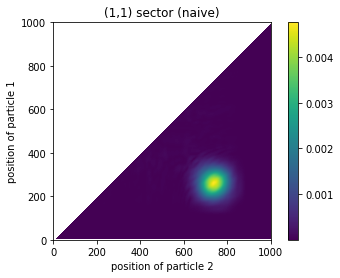

In [27]:
plt.imshow(abs(psi[:,:,0,0]), origin='lower')
plt.title("(1,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

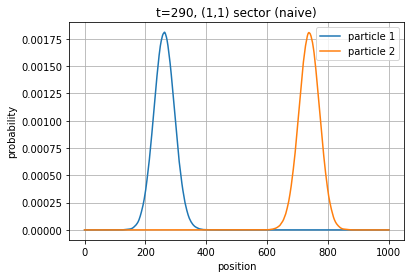

In [28]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,0,0])**2) for i in range(psi.shape[0])], label="particle 1")
plt.plot([np.sum(abs(psi_nn[:,i,0,0])**2) for i in range(psi.shape[1])], label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,1) sector (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

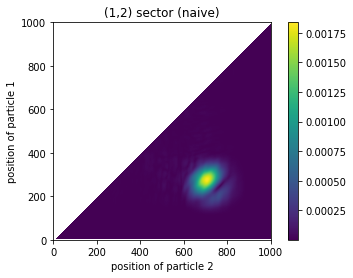

In [29]:
plt.imshow(abs(psi[:,:,0,1]), origin='lower')
plt.title("(1,2) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

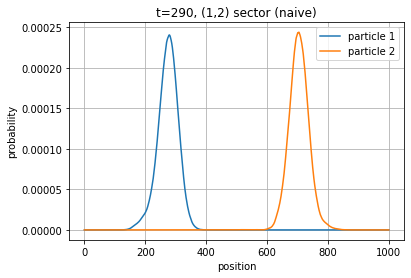

In [30]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,0,1])**2) for i in range(psi.shape[0])], label="particle 1")
plt.plot([np.sum(abs(psi_nn[:,i,0,1])**2) for i in range(psi.shape[1])], label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,2) sector (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

In [31]:
sum([i * np.sum(abs(psi_nn[i,:,0,1])**2) for i in range(psi.shape[0])])/la.norm(psi_nn[:,:,0,1])**2

274.2059976866056

In [32]:
sum([i * np.sum(abs(psi_nn[:,i,0,1])**2) for i in range(psi.shape[1])])/la.norm(psi_nn[:,:,0,1])**2

704.7956601031333

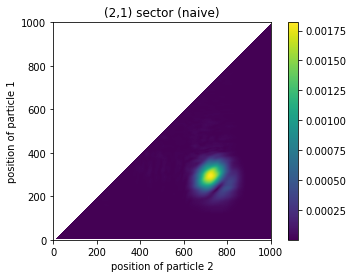

In [33]:
plt.imshow(abs(psi[:,:,1,0]), origin='lower')
plt.title("(2,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

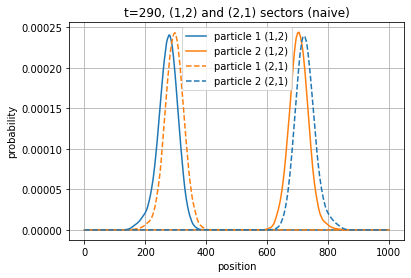

In [34]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,0,1])**2) for i in range(psi.shape[0])], "C0-", label="particle 1 (1,2)")
plt.plot([np.sum(abs(psi_nn[:,i,0,1])**2) for i in range(psi.shape[1])], "C1-", label="particle 2 (1,2)")
plt.plot([np.sum(abs(psi_nn[i,:,1,0])**2) for i in range(psi.shape[0])], "C1--", label="particle 1 (2,1)")
plt.plot([np.sum(abs(psi_nn[:,i,1,0])**2) for i in range(psi.shape[1])], "C0--", label="particle 2 (2,1)")
plt.legend()
plt.title(f"t={t}, (1,2) and (2,1) sectors (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

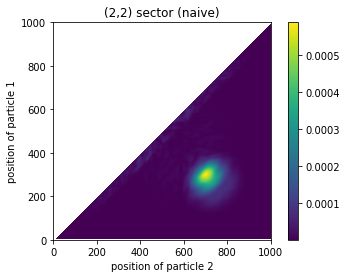

In [35]:
plt.imshow(abs(psi[:,:,1,1]), origin='lower')
plt.title("(2,2) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

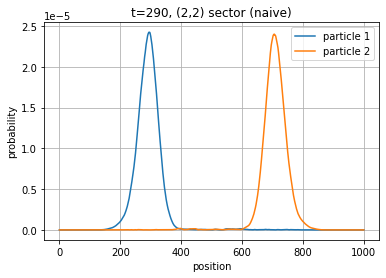

In [36]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,1,1])**2) for i in range(psi.shape[0])], "C0-", label="particle 1")
plt.plot([np.sum(abs(psi_nn[:,i,1,1])**2) for i in range(psi.shape[1])], "C1-", label="particle 2")
plt.legend()
plt.title(f"t={t}, (2,2) sector (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

### Fourier transform (naive)

In [37]:
freqs = fft.fftfreq(psi.shape[0]) * (2*np.pi)

freqs = fft.fftshift(freqs)
psi_ = np.nan_to_num(psi)
nrm = la.norm(psi_)
psik = fft.fft2(psi_, axes=(0,1))
psik *= nrm/la.norm(psik)

psik = fft.fftshift(psik, axes=(0,1))

(-0.6, 0.6)

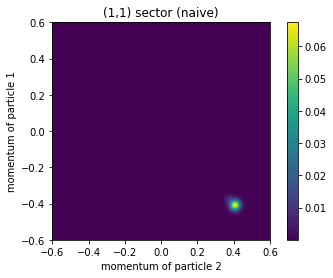

In [38]:
plt.imshow(abs(psik[:,:,0,0]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(1,1) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

(-0.6, 0.6)

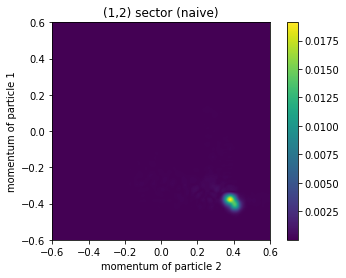

In [39]:
plt.imshow(abs(psik[:,:,0,1]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(1,2) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

(-0.6, 0.6)

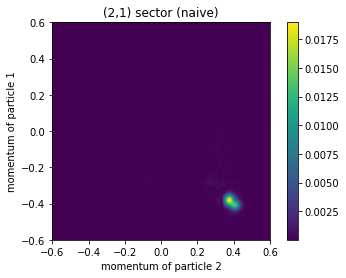

In [40]:
plt.imshow(abs(psik[:,:,1,0]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(2,1) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

(-0.6, 0.6)

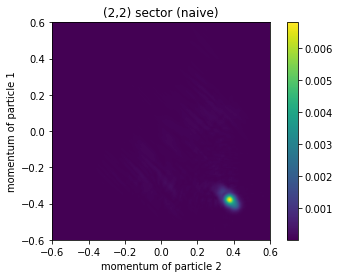

In [41]:
plt.imshow(abs(psik[:,:,1,1]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(2,2) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

In [42]:
1 - la.norm(np.nan_to_num(psi))**2  # projection error (probability)

0.8058313977879139

Mod over position, leaving separation.

In [43]:
nrms_allseps = olaps.nrms_by_sep(psi)

In [44]:
nrms_allseps.shape

(1001, 2, 2)

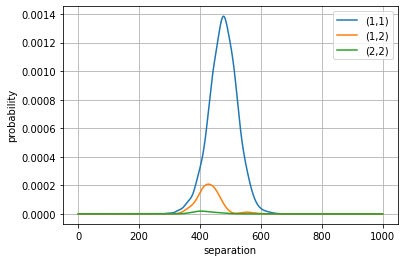

In [45]:
plt.plot(nrms_allseps[:,0,0]**2, label="(1,1)")
plt.plot(nrms_allseps[:,0,1]**2, label="(1,2)")
plt.plot(nrms_allseps[:,1,1]**2, label="(2,2)")
plt.xlabel("separation")
plt.ylabel("probability")
plt.legend()
plt.grid()

## Now handle momentum dependence

In [46]:
ex_specs_L = [(-(mom), 0), (-(mom+0.04), 0), (-(mom-0.04), 0)] # we compute overlaps with excitation tensors for a few different momenta
ex_specs_R = [(mom, 0),  (mom+0.04, 0),  (mom-0.04, 0)]

In [47]:
psi_11, _, sL_11, sR_11, BLs_11, BRs_11 = olaps.overlap_2p_components_specs(
  state, vac, ex_specs_L, ex_specs_R, ortho=True,
  brute=True, force_pseudo=True, verbose=False,
  return_prep_data=True)

Save everything:

In [48]:
psi_fn_comp = simdir + f"psi_comp_2p_11_basis_t{t}.npz"
np.savez_compressed(psi_fn_comp,
                  psi=psi_11, ex_specs_L=ex_specs_L, ex_specs_R=ex_specs_R,
                  BLs=BLs_11, BRs=BRs_11,
                  lL=sL_11.l[0], AL=sL_11.A[0], AC=vac.A[0], AR=sR_11.A[0], rR=sR_11.r[0])

In [49]:
psi_11_nn = np.nan_to_num(psi_11)

In [50]:
la.norm(np.nan_to_num(psi_11))

0.5860368008670142

Let's plot the (still naive) position wavefunction for the momentum 0.4 tensors:

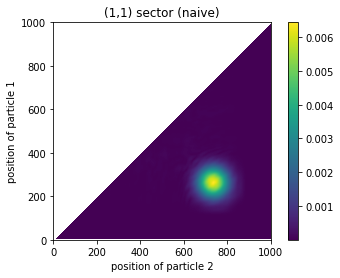

In [51]:
plt.imshow(abs(psi_11[:,:,0,0]), origin='lower')
plt.title("(1,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

Now the next component (which will be small due to orthonormalization).

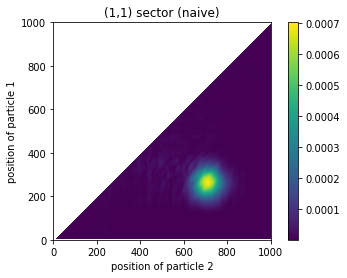

In [52]:
plt.imshow(abs(psi_11[:,:,0,1]), origin='lower')
plt.title("(1,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

## Actual Fourier-mode projection

We use the data collected above, using a few momentum tensors, to parameterize the momentum-dependence on a fine grid (currently N momenta between -pi and pi, where N is the number of lattice sites in the sim. window).

This will take a while, as excitation tensor are computed for each of the N momenta.

In [53]:
res = olaps.get_overlaps_fourier(
    psi_11, sL_11, BLs_11, vac, BRs_11, sR_11,
    0, # left excitation level (adjust to match sector)
    0, # right excitation level (adjust to match sector)
    d_min=0, zero_tol=1e-6)

(1001, 1001, 3, 3) 0.3434391319704444 0.3434391319704444


In [54]:
P_proj, P_red, P_sep, P_psi, psi_red, freqs_nonzero_L, freqs_nonzero_R, Bs_p_basis_L, Bs_p_basis_R = res

In [55]:
np.savez(simdir + f"psi_fourier_2p_11_basis_t{t}.npz", fL=freqs_nonzero_L, fR=freqs_nonzero_R, probs=res[:4], Bs_p_basis_L=Bs_p_basis_L, Bs_p_basis_R=Bs_p_basis_R)

In [56]:
P_psi # Raw probability including all excitation tensors.
# This is typically an overestimate, as the basis is capable of representing excitations in other sectors too.

0.3434391319704444

In [57]:
P_sep  # After dropping poorly-separated terms

0.3434391319704444

In [58]:
P_proj  # This is the final probability after accounting for momentum dependence.

0.3148211320012939

In [59]:
la.norm(psik[:,:,0,0])**2  # Single-tensor (naive) probability of (1,1) from previous computation

0.1545576921575883

In [60]:
psi_red.shape

(108, 103)

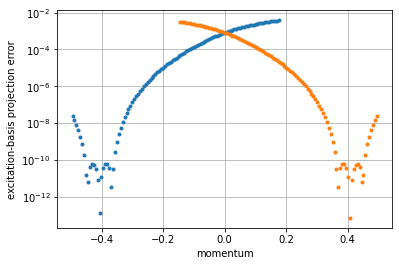

In [61]:
plt.semilogy(freqs_nonzero_L, 1-la.norm(Bs_p_basis_L, axis=2)[:,0], ".")
plt.semilogy(freqs_nonzero_R, 1-la.norm(Bs_p_basis_R, axis=2)[:,0], ".")
plt.xlabel("momentum")
plt.ylabel("excitation-basis projection error")
plt.grid()

Projections are very accurate for momenta close to +/- 0.5. Also not too bad beyond.

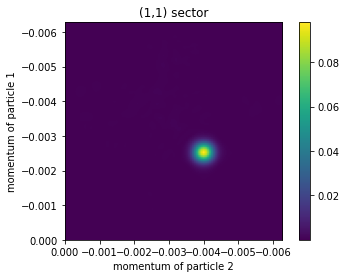

In [62]:
# NOTE: assuming here, for plotting purposes, that freqs_nonzero_X is continuous and sorted
plt.imshow(abs(psi_red), origin='lower',
           extent=(freqs_nonzero_R[0], freqs_nonzero_R[-1], freqs_nonzero_L[0], freqs_nonzero_L[-1]))
plt.title("(1,1) sector")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
#plt.xlim(-0.5,0.5)
#plt.ylim(-0.5,0.5)

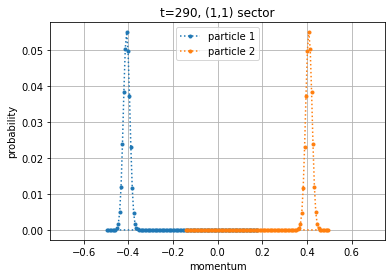

In [63]:
plt.plot(freqs_nonzero_L, [np.sum(abs(psi_red[i,:])**2) for i in range(psi_red.shape[0])], ".:", label="particle 1")
plt.plot(freqs_nonzero_R, [np.sum(abs(psi_red[:,i])**2) for i in range(psi_red.shape[1])], ".:", label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,1) sector")
plt.xlabel("momentum")
plt.ylabel("probability")
plt.xlim(-0.75,0.75)
plt.grid()

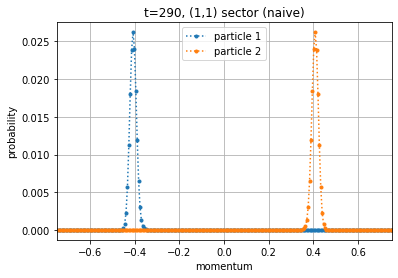

In [64]:
plt.plot(freqs, [np.sum(abs(psik[i,:,0,0])**2) for i in range(psik.shape[0])], ".:", label="particle 1")
plt.plot(freqs, [np.sum(abs(psik[:,i,0,0])**2) for i in range(psik.shape[1])], ".:", label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,1) sector (naive)")
plt.xlabel("momentum")
plt.ylabel("probability")
plt.xlim(-0.75,0.75)
plt.grid()